In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Algorithm Implementation

### Kalman Filter (KF)

In [2]:
def KF(m, C, y, H, GAMMA, XI, A):
    """
    Kalman Filter Algorithm
    input:
        m: mean of the state estimate at the previous time step
        C: error covariance of the state estimate at the previous time step
        y: current observation
        H: observation matrix (linear observation model)
        GAMMA: observation noise covariance matrix
        XI: dynamics noise covariance matrix
        A: dynamics matrix (linear dynamics model)
    output:
        m_updated: updated state estimate
        c_updated: updated error covariance
    """
    d_state = m.shape[0]

    # Part 1: Prediction
    m = A @ m
    C = A @ C @ A.T + XI

    # Part 2: Analysis
    # Innovation
    d = y - H @ m
    # Compute Kalman gain K
    S = H @ C @ H.T + GAMMA
    K = C @ H.T @ np.linalg.solve(S, np.eye(S.shape[0]))
    m_updated = m + K @ d
    # Update the error covariance
    C_updated = (np.eye(d_state) - K @ H) @ C

    return m_updated, C_updated


### Ensemble Kalman Filter (EnKF)

In [3]:
def EnKF(ensemble, y, H, GAMMA, XI, model_func, dt):
    """
    Ensemble Kalman Filter Algorithm
    input:
        ensemble: ensemble members at the previous time step
        y: current observation
        H: observation matrix (linear observation model)
        GAMMA: observation noise covariance matrix
        XI: dynamics noise covariance matrix
        model_func: dynamics model function
        dt: time step
    output:
        ensemble_updated: updated ensemble members
    """
    N_ENS = ensemble.shape[0]
    d_STATE = ensemble.shape[1]

    # Part 1: Prediction
    for i in range(N_ENS):
        ensemble[i] = model_func(ensemble[i], dt, xi=XI)
    # Compute predicted mean by averaging ensembles
    ens_mean = np.mean(ensemble, axis=0)
    ens_residual = ensemble - ens_mean
    # Compute forecast error covariance matrix C
    C = np.cov(ens_residual.T)

    # Part 2: Analysis
    # Compute Kalman gain K
    S = H @ C @ H.T + GAMMA
    K = C @ H.T @ np.linalg.solve(S, np.eye(S.shape[0]))
    ensemble_updated = np.zeros_like(ensemble)
    for i in range(N_ENS):
        # Sample eta from Normal(0, GAMMA)
        eta = np.random.multivariate_normal(np.zeros(GAMMA.shape[0]), GAMMA)
        # Perturb the observation with the sampled eta
        y_mod = y + eta
        # Compute the updated ensemble member
        v = (np.eye(d_STATE) - K @ H) @ ensemble[i] + K @ y_mod
        ensemble_updated[i] = v

    return ensemble_updated

### Ensemble Kalman Filter with Resampling (REnKF)

In [4]:
def REnKF(ensemble, y, H, GAMMA, XI, model_func, dt):
    """
    Ensemble Kalman Filter with Resampling
    input:
        ensemble: ensemble members at the previous time step
        y: current observation
        H: observation matrix (linear observation model)
        GAMMA: observation noise covariance matrix
        XI: dynamics noise covariance matrix
        model_func: dynamics model function
        dt: time step
    output:
        ensemble_resampled: updated resampled ensemble members
    """
    N_ENS = ensemble.shape[0]
    d_STATE = ensemble.shape[1]

    # Part 1: Prediction
    for i in range(N_ENS):
        ensemble[i] = model_func(ensemble[i], dt, xi=XI)
    # Compute predicted mean by averaging ensembles
    ens_mean = np.mean(ensemble, axis=0)
    ens_residual = ensemble - ens_mean
    # Compute forecast error covariance matrix C
    C = np.cov(ens_residual.T)

    # Part 2: Analysis
    # Compute Kalman gain K
    S = H @ C @ H.T + GAMMA
    K = C @ H.T @ np.linalg.solve(S, np.eye(S.shape[0]))
    ensemble_updated = np.zeros_like(ensemble)
    for i in range(N_ENS):
        # Sample eta from Normal(0, GAMMA)
        eta = np.random.multivariate_normal(np.zeros(GAMMA.shape[0]), GAMMA)
        # Perturb the observation with the sampled eta
        y_mod = y + eta
        # Compute the updated ensemble member
        v = (np.eye(d_STATE) - K @ H) @ ensemble[i] + K @ y_mod
        ensemble_updated[i] = v

    # Part 3: Resample
    # Compute updated sample mean and covariance
    updated_mean = np.mean(ensemble_updated, axis=0)
    updated_cov = np.cov(ensemble_updated.T)
    # Resample the ensemble members
    ensemble_resampled = np.zeros_like(ensemble_updated)
    for i in range(N_ENS):
        ensemble_resampled[i] = np.random.multivariate_normal(updated_mean, updated_cov)
    return ensemble_resampled


## KF / EnKF / REnKF for Linear Setting

This section contains the code used to compute all the cases in Table 2, generating Figure 1, and the supplementary results (moderate and large noise cases) related to Figure 1.

For each experiment in the table, we run each algorithm M = 100 times and report the average value of the three metrics. More details can be found in Appendix A.1. of the paper. 
The metrics mean error, confidence interval (C.I.) width, and confidence interval (C.I.) coverage descriptions can also be found in Appendix A.1 of the paper.

- observation time: $J=200$; &nbsp; fixed ensemble size $N=10/40$; &nbsp; fixed state dimension $d=20$
- small noise level $\alpha=10^{-4}$,  &nbsp; moderate noise level $\alpha=10^{-2}$, &nbsp; and large noise level $\alpha=10^{-1}$
- initial distribution: $u^{(0)} \sim \mathcal{N}(\mathbf{0}, \Sigma^{(0)});$ &nbsp; $\Sigma^{(0)} = 1.1 \alpha \times I_{20}$
- dynamics model: $u^{(j)} = Au^{(j-1)} + \xi^{(j)}$
    - linear dynamics $A = I_{20}$
    - gaussian noise $\xi^{(j)} \overset{\mathrm{iid}}{\sim} \mathcal{N}(0, \Xi)$; &nbsp; $\Xi = \alpha \times I_{20}$
- observation model: $y^{(j)} = Hu^{(j)} + \eta^{(j)}$
    - linear full observation $H = I_{20}$
    - gaussian noise $\eta^{(j)} \overset{\mathrm{iid}}{\sim} \mathcal{N}(0, \Gamma)$; &nbsp; $\Gamma = \alpha \times I_{20}$

In [5]:
def linear_model(state, dt=None, xi=None):
    # Stochastic dynamics
    if xi is not None:
        state += np.random.multivariate_normal(np.zeros(len(state)), xi)

    return state

### Small Noise $\alpha = 10^{-4}$

#### Visualization of 1st dimension $u(1)$ for 1 Monte-Carlo Trial for Small Noise $\alpha = 10^{-4}$
(code for Figure 1 in the paper)

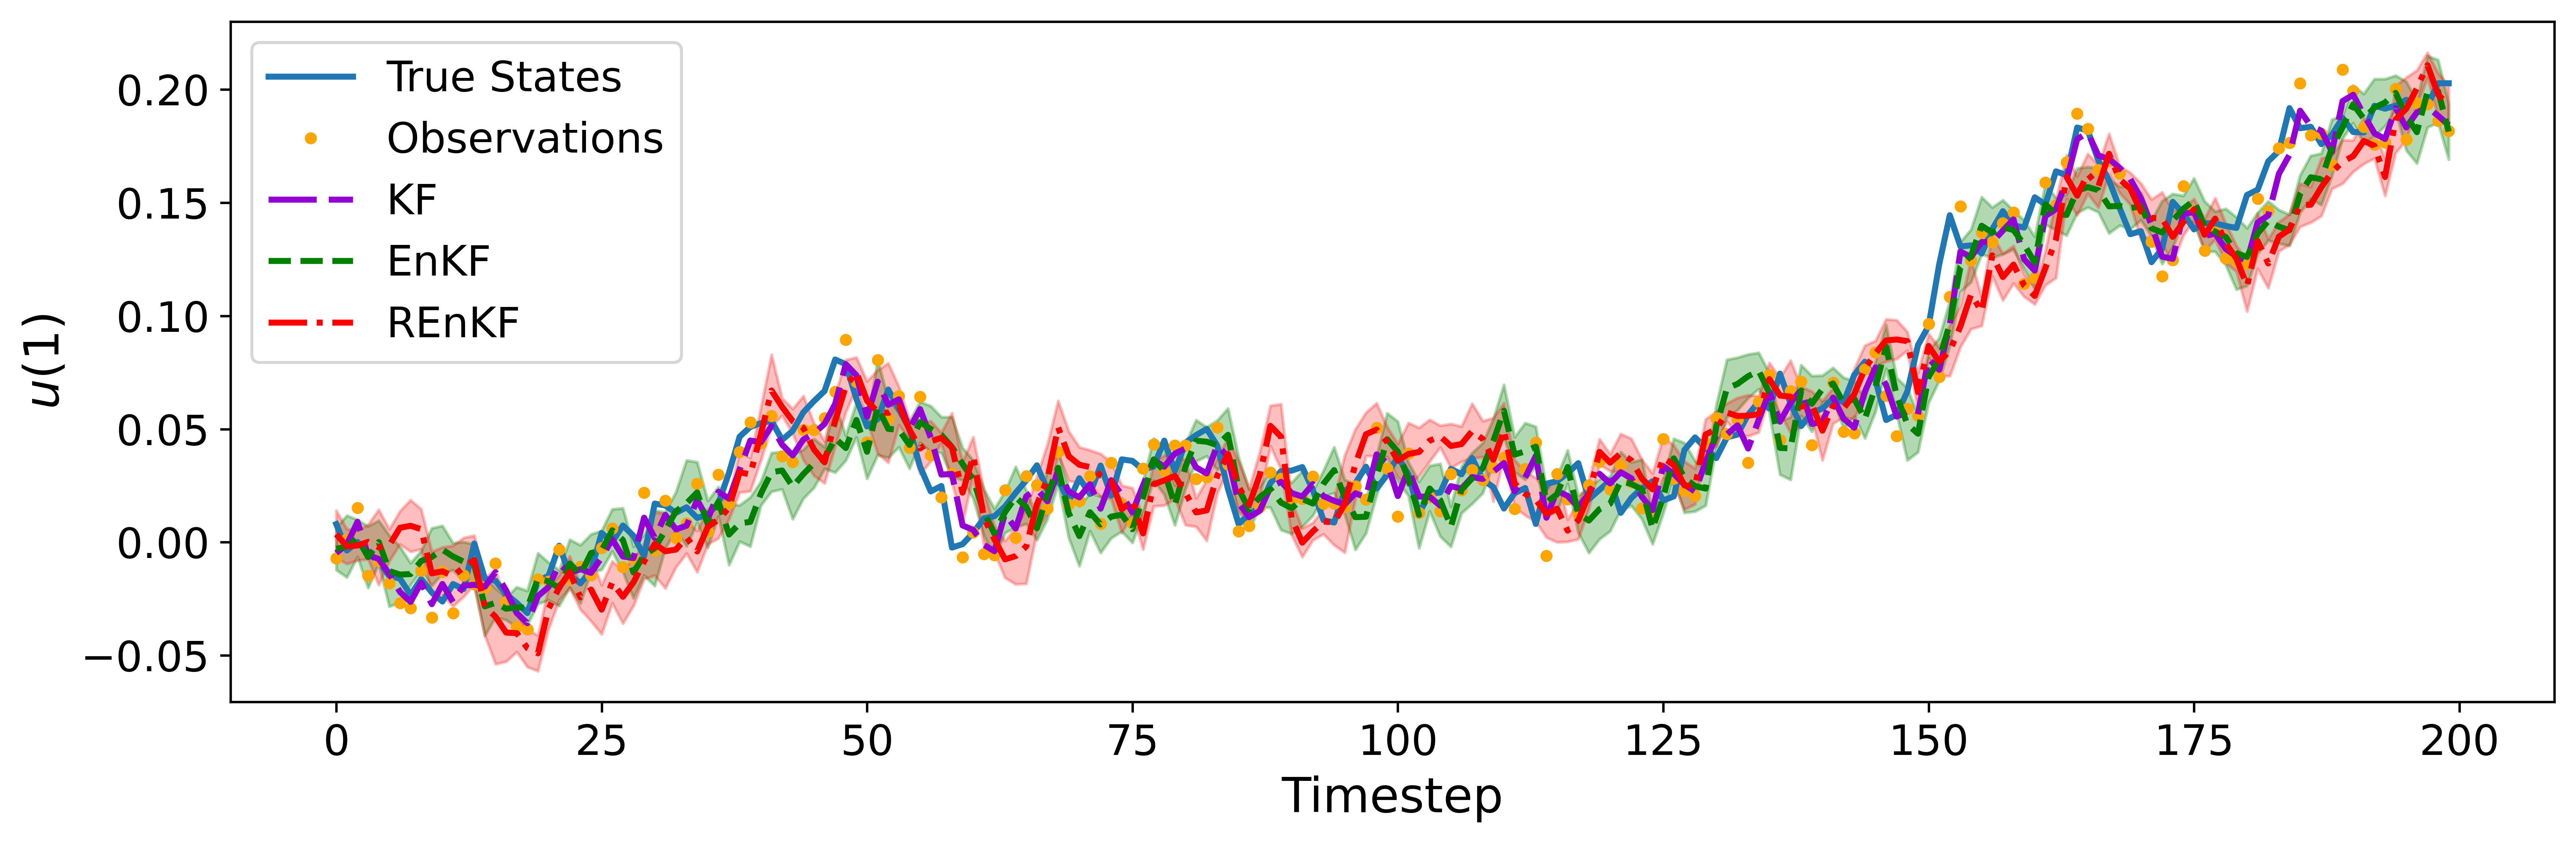

In [6]:
# Settings
np.random.seed(0)
T_END = 200
dt = 1
N_ENS = 10  # number of ensembles
D_DIM = 20
ALPHA = 1e-4

# Define observation model and its noise covariance matrix - linear full observation
H = np.eye(D_DIM)
GAMMA = np.eye(D_DIM) * ALPHA
# Define dynamics model and its noise covariance matrix - linear identity dynamics
A = np.eye(D_DIM)
XI = np.eye(D_DIM) * ALPHA
# Generate synthetic true state and observations
x_true = np.zeros((T_END, D_DIM))
x_obs = np.zeros((T_END, D_DIM))
# Define initial mean and covariance matrix
X_INIT = np.zeros(D_DIM)
SIGMA_INIT = np.eye(D_DIM) * 1.1 * ALPHA
x_true[0] = np.random.multivariate_normal(X_INIT, SIGMA_INIT)
x_obs[0] = x_true[0] + np.random.multivariate_normal(np.zeros(D_DIM), GAMMA)
for t in range(1, T_END):
    x_true[t] = linear_model(x_true[t - 1], xi=XI)
    x_obs[t] = x_true[t] + np.random.multivariate_normal(np.zeros(D_DIM), GAMMA)
# Initialize state mean and covariance for KF
m = X_INIT
C = SIGMA_INIT
# Initialize ensemble members for EnKF and REnKF
ensemble_EnKF = np.random.multivariate_normal(X_INIT, SIGMA_INIT, size=N_ENS)
ensemble_REnKF = np.random.multivariate_normal(X_INIT, SIGMA_INIT, size=N_ENS)
# Initialize state estimates for KF, EnKF, and REnKF
state_estimates_KF = np.zeros((T_END, D_DIM))
state_estimates_EnKF = np.zeros((T_END, D_DIM))
state_estimates_REnKF = np.zeros((T_END, D_DIM))
# Initialize arrays to store ensemble members of each time step
ensemble_EnKF_list = np.zeros((T_END, N_ENS, D_DIM))
ensemble_REnKF_list = np.zeros((T_END, N_ENS, D_DIM))

for t in range(T_END):
    # Run KF
    m, C = KF(m, C, x_obs[t], H, GAMMA, XI, A)
    # Store state estimates for each time step for KF
    state_estimates_KF[t] = m
    # Run EnKF and REnKF
    ensemble_EnKF = EnKF(ensemble_EnKF, x_obs[t], H, GAMMA, XI, linear_model, dt)
    ensemble_REnKF = REnKF(ensemble_REnKF, x_obs[t], H, GAMMA, XI, linear_model, dt)
    # Store ensemble members for each time step
    ensemble_EnKF_list[t] = ensemble_EnKF
    ensemble_REnKF_list[t] = ensemble_REnKF
    # Store ensemble mean as state estimate for EnKF and REnKF
    state_estimates_EnKF[t] = np.mean(ensemble_EnKF, axis=0)
    state_estimates_REnKF[t] = np.mean(ensemble_REnKF, axis=0)

# Compute the standard deviation of the ensemble for each time step for EnKF and REnKF
std_devs_EnKF = np.std(ensemble_EnKF_list, axis=1)
std_devs_REnKF = np.std(ensemble_REnKF_list, axis=1)

# Define the plot helper function
def plot_results(state_estimates_KF, state_estimates_EnKF, state_estimates_REnKF,
 std_devs_EnKF, std_devs_REnKF, x_true, x_obs, variables):
    T_END = state_estimates_KF.shape[0]
    timesteps = np.arange(T_END)
    plt.figure(figsize=(12, 4*len(variables)), dpi=600)
    for i, var in enumerate(variables):
        plt.subplot(len(variables), 1, i+1)
        plt.plot(timesteps, x_true[:, var], '-', label='True States', lw=2)
        plt.plot(timesteps, x_obs[:, var], '.', label='Observations', color='orange')
        plt.plot(timesteps, state_estimates_KF[:, var], color='darkviolet', label='KF', lw=2, dashes=[8, 2])
        plt.plot(timesteps, state_estimates_EnKF[:, var], '--', label='EnKF', color='green', lw=2)
        plt.fill_between(timesteps, state_estimates_EnKF[:, var] - 1.96*std_devs_EnKF[:, var],
                         state_estimates_EnKF[:, var] + 1.96*std_devs_EnKF[:, var], alpha=0.3, color='green')
        plt.plot(timesteps, state_estimates_REnKF[:, var], '-.', label='REnKF', color='red', lw=2)
        plt.fill_between(timesteps, state_estimates_REnKF[:, var] - 1.96*std_devs_REnKF[:, var],
                         state_estimates_REnKF[:, var] + 1.96*std_devs_REnKF[:, var], alpha=0.25, color='red')
        plt.xlabel('Timestep', fontsize=16)
        plt.ylabel(r'$u({})$'.format(var+1), fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

plot_results(state_estimates_KF, state_estimates_EnKF, state_estimates_REnKF, std_devs_EnKF,
 std_devs_REnKF, x_true, x_obs, variables=[0])

In [7]:
def run_linear_experiment(N_ENS, M=100, X_INIT=X_INIT, SIGMA_INIT=SIGMA_INIT, x_true=x_true, x_obs=x_obs, GAMMA=GAMMA,
                           XI=XI, A=A, D_DIM=D_DIM, linear_model=linear_model, H=H, dt=dt, T_END=T_END):
    # Helper function for calculation of linear table
    # Create arrays to store the results of each iteration
    ensemble_mean_error_EnKF_list = np.zeros(M)
    ensemble_mean_error_REnKF_list = np.zeros(M)
    average_CI_width_EnKF_list = np.zeros(M)
    average_CI_width_REnKF_list = np.zeros(M)
    percentage_in_CI_EnKF_list = np.zeros(M)
    percentage_in_CI_REnKF_list = np.zeros(M)

    # Initialize state estimates for KF
    state_estimates_KF = np.zeros((T_END, D_DIM))
    # Initialize state mean and covariance for KF
    m = X_INIT
    C = SIGMA_INIT

    # Run KF
    for t in range(T_END):
        m, C = KF(m, C, x_obs[t], H, GAMMA, XI, A)
        # Store state estimates for KF
        state_estimates_KF[t] = m

    for iter in range(M):
        np.random.seed(iter)
        # Initialize ensemble members for EnKF and REnKF
        ensemble_EnKF = np.random.multivariate_normal(X_INIT, SIGMA_INIT, size=N_ENS)
        ensemble_REnKF = np.random.multivariate_normal(X_INIT, SIGMA_INIT, size=N_ENS)
        # Initialize state estimates and covariance estimates for EnKF, and REnKF
        state_estimates_EnKF = np.zeros((T_END, D_DIM))
        state_estimates_REnKF = np.zeros((T_END, D_DIM))
        # Initialize mean error of EnKF and REnKF compared to KF
        ensemble_mean_error_EnKF = np.zeros(T_END)
        ensemble_mean_error_REnKF = np.zeros(T_END)
        # Initialize arrays to store ensemble members of each time step
        ensemble_EnKF_list = np.zeros((T_END, N_ENS, D_DIM))
        ensemble_REnKF_list = np.zeros((T_END, N_ENS, D_DIM))

        for t in range(T_END):
            # Run EnKF and REnKF
            ensemble_EnKF = EnKF(ensemble_EnKF, x_obs[t], H, GAMMA, XI, linear_model, dt)
            ensemble_REnKF = REnKF(ensemble_REnKF, x_obs[t], H, GAMMA, XI, linear_model, dt)
            # Store ensemble members for each time step
            ensemble_EnKF_list[t] = ensemble_EnKF
            ensemble_REnKF_list[t] = ensemble_REnKF
            # Store ensemble mean as state estimate for EnKF and REnKF
            state_estimates_EnKF[t] = np.mean(ensemble_EnKF, axis=0)
            state_estimates_REnKF[t] = np.mean(ensemble_REnKF, axis=0)
            # Compute the mean error of EnKF and REnKF compared to KF
            ensemble_mean_error_EnKF[t] = np.linalg.norm((state_estimates_EnKF[t] - state_estimates_KF[t]))
            ensemble_mean_error_REnKF[t] = np.linalg.norm((state_estimates_REnKF[t] - state_estimates_KF[t]))

        # Compute average mean errors across all time steps
        ensemble_mean_error_EnKF_list[iter] = np.mean(ensemble_mean_error_EnKF)
        ensemble_mean_error_REnKF_list[iter] = np.mean(ensemble_mean_error_REnKF)
        # Compute the standard deviation of the ensemble for each time step for EnKF and REnKF
        std_devs_EnKF = np.std(ensemble_EnKF_list, axis=1)
        std_devs_REnKF = np.std(ensemble_REnKF_list, axis=1)
        # Compute confidence interval for each time step and method
        widths_EnKF = 1.96 * 2 * std_devs_EnKF
        widths_REnKF = 1.96 * 2 * std_devs_REnKF
        # Compute average width of confidence intervals for each method
        average_width_EnKF = np.mean(widths_EnKF, axis=0)
        average_width_REnKF = np.mean(widths_REnKF, axis=0)
        # Compute average width of confidence intervals across all dimensions
        average_CI_width_EnKF_list[iter] = np.mean(average_width_EnKF)
        average_CI_width_REnKF_list[iter] = np.mean(average_width_REnKF)
        # Calculate coverages for EnKF
        mask_EnKF = (x_true >= (state_estimates_EnKF - 1.96*std_devs_EnKF)) & (x_true <= (state_estimates_EnKF +
         1.96*std_devs_EnKF))
        percentage_in_CI_EnKF = np.mean(mask_EnKF) * 100
        percentage_in_CI_EnKF_list[iter] = percentage_in_CI_EnKF
        # Calculate coverages for REnKF
        mask_REnKF = (x_true >= (state_estimates_REnKF - 1.96*std_devs_REnKF)) & (x_true <= (state_estimates_REnKF +
        1.96*std_devs_REnKF))
        percentage_in_CI_REnKF = np.mean(mask_REnKF) * 100
        percentage_in_CI_REnKF_list[iter] = percentage_in_CI_REnKF

    print("Averaged EnKF Mean Error over 100 Monte-Carlo Trials:", np.mean(ensemble_mean_error_EnKF_list))
    print("Averaged REnKF Mean Error over 100 Monte-Carlo Trials", np.mean(ensemble_mean_error_REnKF_list))
    print()
    print("Averaged EnKF C.I. Width over 100 Monte-Carlo Trials", np.mean(average_CI_width_EnKF_list))
    print("Averaged REnKF C.I. Width over 100 Monte-Carlo Trials", np.mean(average_CI_width_REnKF_list))
    print()
    print("Averaged EnKF C.I. Coverage(%) over 100 Monte-Carlo Trials", np.mean(percentage_in_CI_EnKF_list))
    print("Averaged REnKF C.I. Coverage(%) over 100 Monte-Carlo Trials", np.mean(percentage_in_CI_REnKF_list))

#### Calculation for Small Noise + N=10
(code for Table 2 in the paper)

In [8]:
run_linear_experiment(N_ENS=10, x_true=x_true, x_obs=x_obs, SIGMA_INIT=SIGMA_INIT, GAMMA=GAMMA, XI=XI)

Averaged EnKF Mean Error over 100 Monte-Carlo Trials: 0.06077889564803157
Averaged REnKF Mean Error over 100 Monte-Carlo Trials 0.0615563755039962

Averaged EnKF C.I. Width over 100 Monte-Carlo Trials 0.01939597047770097
Averaged REnKF C.I. Width over 100 Monte-Carlo Trials 0.01875092112216836

Averaged EnKF C.I. Coverage(%) over 100 Monte-Carlo Trials 39.57175
Averaged REnKF C.I. Coverage(%) over 100 Monte-Carlo Trials 37.83125


#### Calculation for Small Noise + N=40
(code for Table 2 in the paper)

In [9]:
run_linear_experiment(N_ENS=40, x_true=x_true, x_obs=x_obs, SIGMA_INIT=SIGMA_INIT, GAMMA=GAMMA, XI=XI)

Averaged EnKF Mean Error over 100 Monte-Carlo Trials: 0.019257133963919894
Averaged REnKF Mean Error over 100 Monte-Carlo Trials 0.020911628539959298

Averaged EnKF C.I. Width over 100 Monte-Carlo Trials 0.027796246844561227
Averaged REnKF C.I. Width over 100 Monte-Carlo Trials 0.027395938309682375

Averaged EnKF C.I. Coverage(%) over 100 Monte-Carlo Trials 69.9355
Averaged REnKF C.I. Coverage(%) over 100 Monte-Carlo Trials 68.64625000000001


### Moderate Noise $\alpha = 10^{-2}$ 

#### Visualization of 1st dimension $u(1)$ for 1 Monte-Carlo Trial for Moderate Noise $\alpha = 10^{-2}$ 
(supplementary results of Figure 1 in the paper)

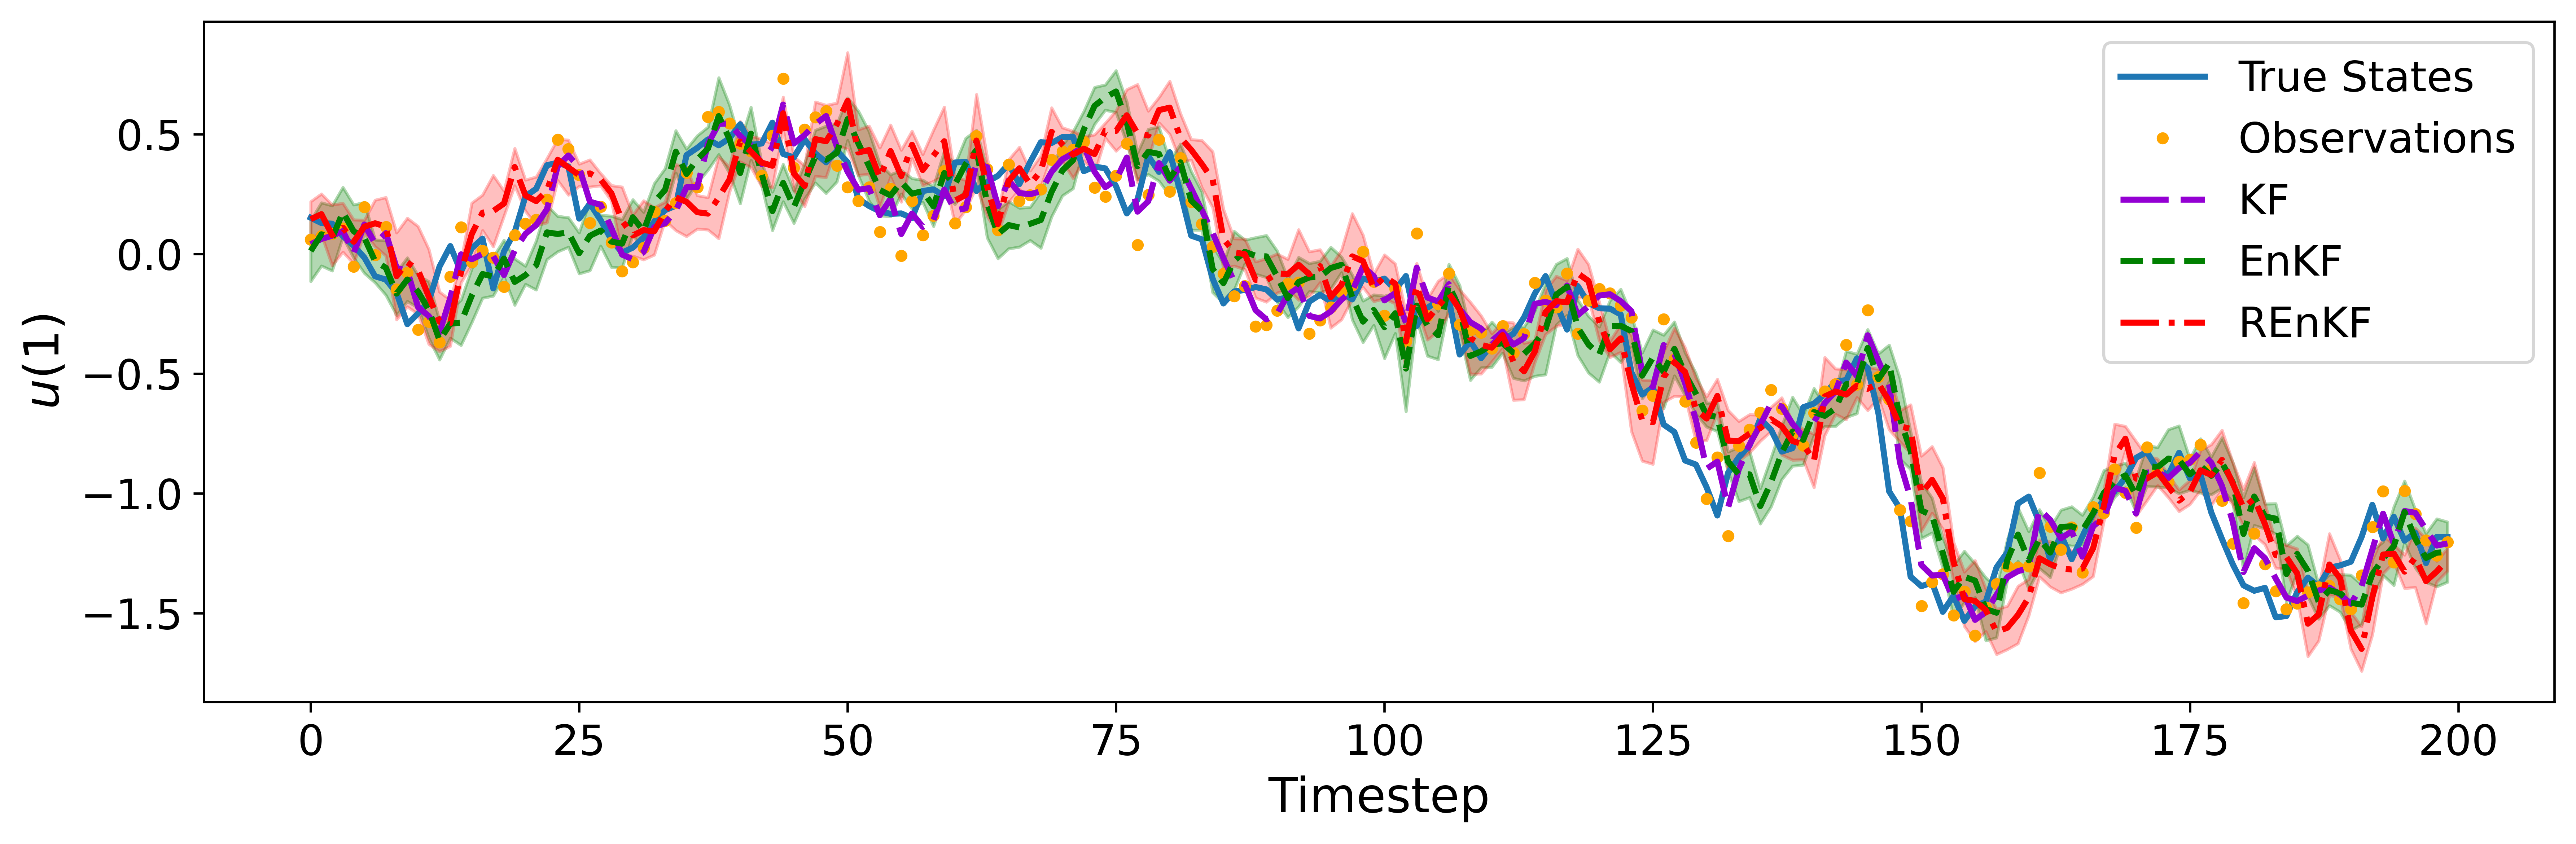

In [10]:
# Settings
np.random.seed(1)
T_END = 200
dt = 1
N_ENS = 10  # number of ensembles
D_DIM = 20
ALPHA = 0.01

# Define observation model and its noise covariance matrix - linear full observation
H = np.eye(D_DIM)
GAMMA = np.eye(D_DIM) * ALPHA
# Define dynamics model and its noise covariance matrix - linear identity dynamics
A = np.eye(D_DIM)
XI = np.eye(D_DIM) * ALPHA
# Generate synthetic true state and observations
x_true = np.zeros((T_END, D_DIM))
x_obs = np.zeros((T_END, D_DIM))
# Define initial mean and dynamics noise covariance matrix at time step 0
X_INIT = np.zeros(D_DIM)
SIGMA_INIT = np.eye(D_DIM) * 1.1 * ALPHA
x_true[0] = np.random.multivariate_normal(X_INIT, SIGMA_INIT)
x_obs[0] = x_true[0] + np.random.multivariate_normal(np.zeros(D_DIM), GAMMA)
for t in range(1, T_END):
    x_true[t] = linear_model(x_true[t - 1], xi=XI)
    x_obs[t] = x_true[t] + np.random.multivariate_normal(np.zeros(D_DIM), GAMMA)
# Initialize state mean and covariance for KF
m = X_INIT
C = SIGMA_INIT
# Initialize ensemble members for EnKF and REnKF
ensemble_EnKF = np.random.multivariate_normal(X_INIT, SIGMA_INIT, size=N_ENS)
ensemble_REnKF = np.random.multivariate_normal(X_INIT, SIGMA_INIT, size=N_ENS)
# Initialize state estimates for KF, EnKF, and REnKF
state_estimates_KF = np.zeros((T_END, D_DIM))
state_estimates_EnKF = np.zeros((T_END, D_DIM))
state_estimates_REnKF = np.zeros((T_END, D_DIM))
# Initialize arrays to store ensemble members of each time step
ensemble_EnKF_list = np.zeros((T_END, N_ENS, D_DIM))
ensemble_REnKF_list = np.zeros((T_END, N_ENS, D_DIM))

# Run KF, EnKF and REnKF
for t in range(T_END):
    # Run KF
    # Perform KF update
    m, C = KF(m, C, x_obs[t], H, GAMMA, XI, A)
    # Store state estimates for each time step
    state_estimates_KF[t] = m
    # Run EnKF and REnKF
    # Perform ensemble prediction and analysis steps for EnKF and REnKF
    ensemble_EnKF = EnKF(ensemble_EnKF, x_obs[t], H, GAMMA, XI, linear_model, dt)
    ensemble_REnKF = REnKF(ensemble_REnKF, x_obs[t], H, GAMMA, XI, linear_model, dt)
    # Store ensemble members for each time step
    ensemble_EnKF_list[t] = ensemble_EnKF
    ensemble_REnKF_list[t] = ensemble_REnKF
    # Store ensemble mean as state estimate for EnKF and REnKF
    state_estimates_EnKF[t] = np.mean(ensemble_EnKF, axis=0)
    state_estimates_REnKF[t] = np.mean(ensemble_REnKF, axis=0)

# Compute the standard deviation of the ensemble for each time step for EnKF and REnKF
std_devs_EnKF = np.std(ensemble_EnKF_list, axis=1)
std_devs_REnKF = np.std(ensemble_REnKF_list, axis=1)

plot_results(state_estimates_KF, state_estimates_EnKF, state_estimates_REnKF, std_devs_EnKF,
 std_devs_REnKF, x_true, x_obs, variables=[0])

#### Calculation for Moderate Noise + N=10
(code for Table 2 in the paper)

In [11]:
run_linear_experiment(N_ENS=10, x_true=x_true, x_obs=x_obs, SIGMA_INIT=SIGMA_INIT, GAMMA=GAMMA, XI=XI)

Averaged EnKF Mean Error over 100 Monte-Carlo Trials: 0.6133347223036548
Averaged REnKF Mean Error over 100 Monte-Carlo Trials 0.6199025069205751

Averaged EnKF C.I. Width over 100 Monte-Carlo Trials 0.19395970477700977
Averaged REnKF C.I. Width over 100 Monte-Carlo Trials 0.18750789191806022

Averaged EnKF C.I. Coverage(%) over 100 Monte-Carlo Trials 38.90025
Averaged REnKF C.I. Coverage(%) over 100 Monte-Carlo Trials 37.135999999999996


#### Calculation for Moderate Noise + N=40
(code for Table 2 in the paper)

In [12]:
run_linear_experiment(N_ENS=40, x_true=x_true, x_obs=x_obs, SIGMA_INIT=SIGMA_INIT, GAMMA=GAMMA, XI=XI)

Averaged EnKF Mean Error over 100 Monte-Carlo Trials: 0.193040006274997
Averaged REnKF Mean Error over 100 Monte-Carlo Trials 0.2090709341463683

Averaged EnKF C.I. Width over 100 Monte-Carlo Trials 0.2779624684456123
Averaged REnKF C.I. Width over 100 Monte-Carlo Trials 0.2739096170943595

Averaged EnKF C.I. Coverage(%) over 100 Monte-Carlo Trials 69.2615
Averaged REnKF C.I. Coverage(%) over 100 Monte-Carlo Trials 67.7565


### Large Noise $\alpha = 10^{-1}$ 

#### Visualization of 1st dimension $u(1)$ for 1 Monte-Carlo Trial for Large Noise $\alpha = 10^{-1}$ 
(supplementary results of Figure 1 in the paper)

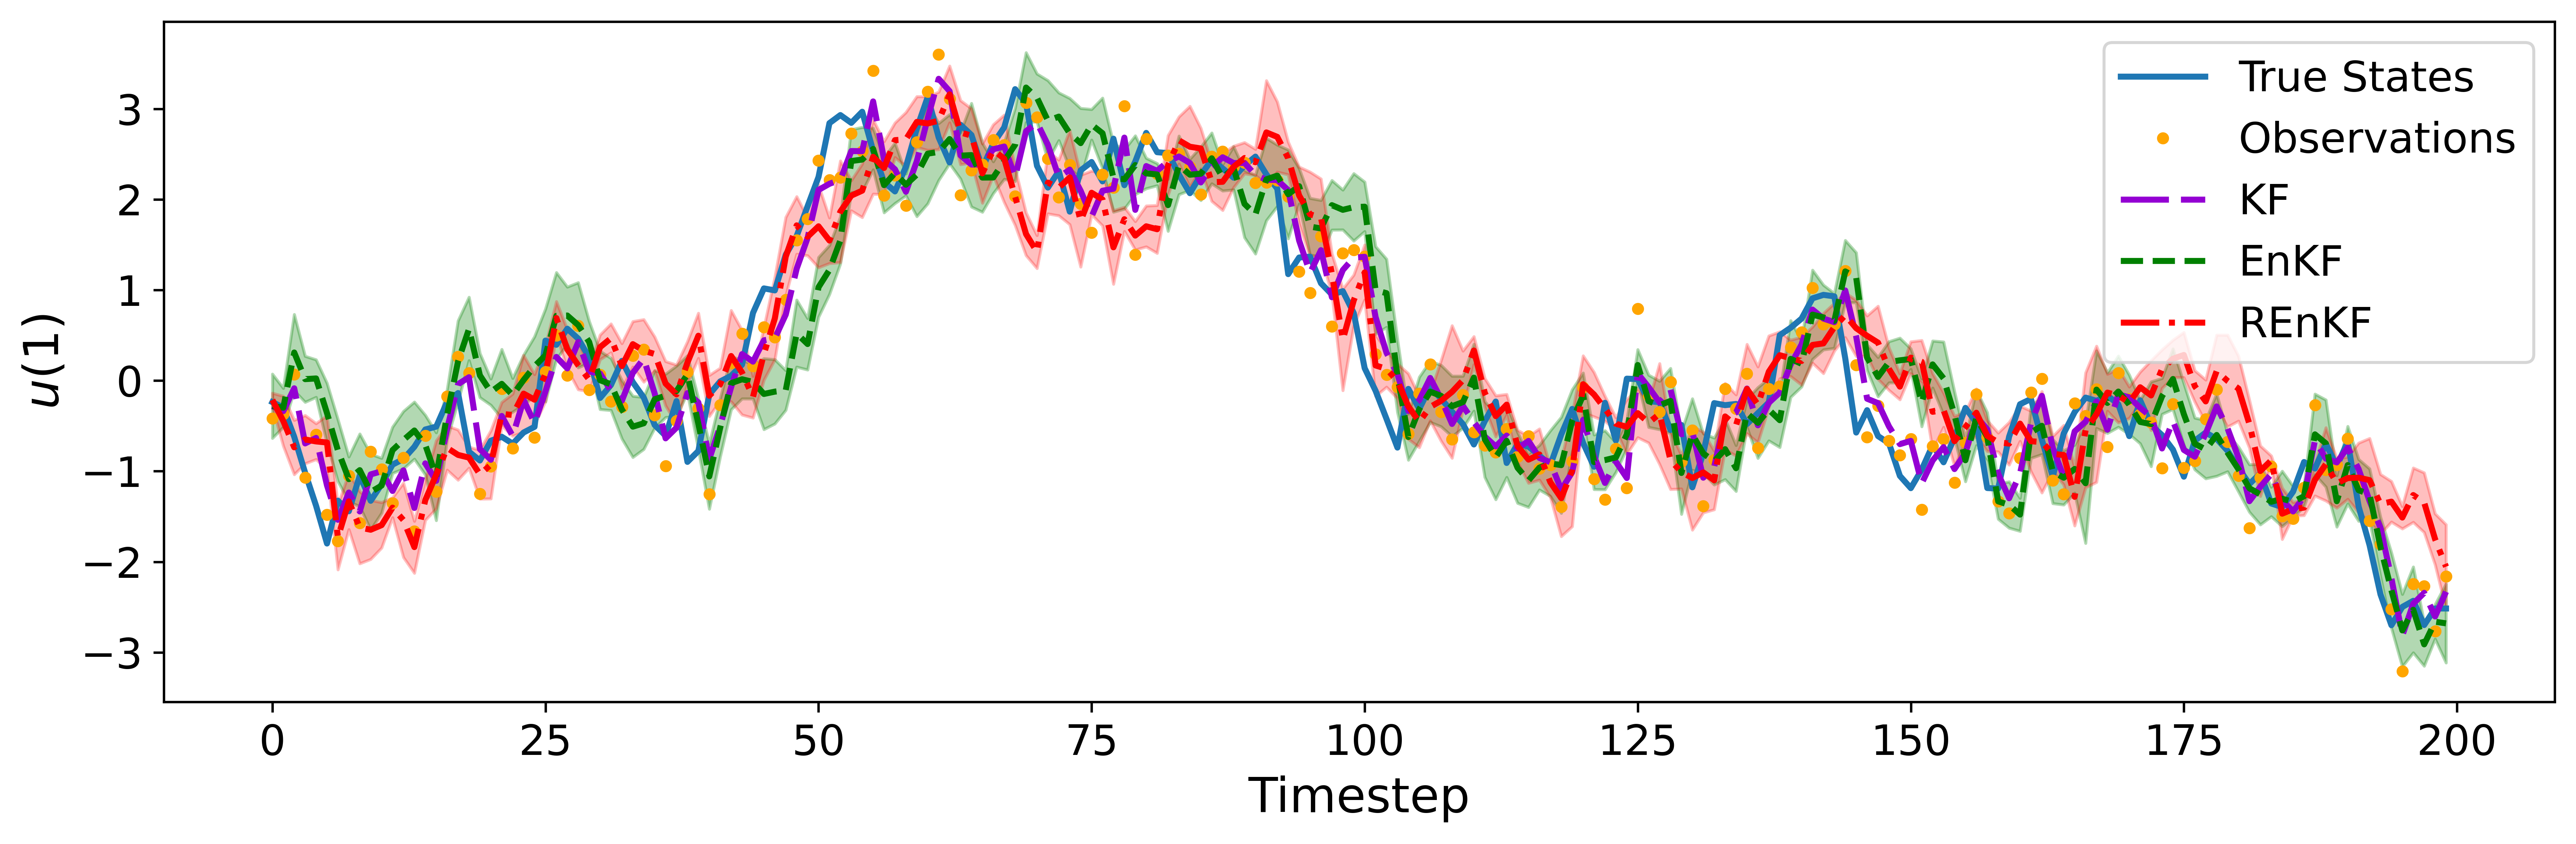

In [13]:
# Settings
np.random.seed(2)
T_END = 200
dt = 1
N_ENS = 10  # number of ensembles
D_DIM = 20
ALPHA = 0.1

# Define observation model and its noise covariance matrix - linear full observation
H = np.eye(D_DIM)
GAMMA = np.eye(D_DIM) * ALPHA
# Define dynamics model and its noise covariance matrix - linear identity dynamics
A = np.eye(D_DIM)
XI = np.eye(D_DIM) * ALPHA
# Generate synthetic true state and observations
x_true = np.zeros((T_END, D_DIM))
x_obs = np.zeros((T_END, D_DIM))
# Define initial mean and dynamics noise covariance matrix at time step 0
X_INIT = np.zeros(D_DIM)
SIGMA_INIT = np.eye(D_DIM) * 1.1 * ALPHA
x_true[0] = np.random.multivariate_normal(X_INIT, SIGMA_INIT)
x_obs[0] = x_true[0] + np.random.multivariate_normal(np.zeros(D_DIM), GAMMA)
for t in range(1, T_END):
    x_true[t] = linear_model(x_true[t - 1], xi=XI)
    x_obs[t] = x_true[t] + np.random.multivariate_normal(np.zeros(D_DIM), GAMMA)
# Initialize state mean and covariance for KF
m = X_INIT
C = SIGMA_INIT
# Initialize ensemble members for EnKF and REnKF
ensemble_EnKF = np.random.multivariate_normal(X_INIT, SIGMA_INIT, size=N_ENS)
ensemble_REnKF = np.random.multivariate_normal(X_INIT, SIGMA_INIT, size=N_ENS)
# Initialize state estimates for KF, EnKF, and REnKF
state_estimates_KF = np.zeros((T_END, D_DIM))
state_estimates_EnKF = np.zeros((T_END, D_DIM))
state_estimates_REnKF = np.zeros((T_END, D_DIM))
# Initialize arrays to store ensemble members of each time step
ensemble_EnKF_list = np.zeros((T_END, N_ENS, D_DIM))
ensemble_REnKF_list = np.zeros((T_END, N_ENS, D_DIM))

# Run KF, EnKF and REnKF
for t in range(T_END):
    # Run KF
    # Perform KF update
    m, C = KF(m, C, x_obs[t], H, GAMMA, XI, A)
    # Store state estimates for each time step
    state_estimates_KF[t] = m
    # Run EnKF and REnKF
    # Perform ensemble prediction and analysis steps for EnKF and REnKF
    ensemble_EnKF = EnKF(ensemble_EnKF, x_obs[t], H, GAMMA, XI, linear_model, dt)
    ensemble_REnKF = REnKF(ensemble_REnKF, x_obs[t], H, GAMMA, XI, linear_model, dt)
    # Store ensemble members for each time step
    ensemble_EnKF_list[t] = ensemble_EnKF
    ensemble_REnKF_list[t] = ensemble_REnKF
    # Store ensemble mean as state estimate for EnKF and REnKF
    state_estimates_EnKF[t] = np.mean(ensemble_EnKF, axis=0)
    state_estimates_REnKF[t] = np.mean(ensemble_REnKF, axis=0)

# Compute the standard deviation of the ensemble for each time step for EnKF and REnKF
std_devs_EnKF = np.std(ensemble_EnKF_list, axis=1)
std_devs_REnKF = np.std(ensemble_REnKF_list, axis=1)

plot_results(state_estimates_KF, state_estimates_EnKF, state_estimates_REnKF, std_devs_EnKF,
 std_devs_REnKF, x_true, x_obs, variables=[0])

#### Calculation for Large Noise + N=10
(code for Table 2 in the paper)

In [14]:
run_linear_experiment(N_ENS=10, x_true=x_true, x_obs=x_obs, SIGMA_INIT=SIGMA_INIT, GAMMA=GAMMA, XI=XI)

Averaged EnKF Mean Error over 100 Monte-Carlo Trials: 1.9930726545488513
Averaged REnKF Mean Error over 100 Monte-Carlo Trials 2.0309918637426274

Averaged EnKF C.I. Width over 100 Monte-Carlo Trials 0.613354441389192
Averaged REnKF C.I. Width over 100 Monte-Carlo Trials 0.5929793085526858

Averaged EnKF C.I. Coverage(%) over 100 Monte-Carlo Trials 38.35025
Averaged REnKF C.I. Coverage(%) over 100 Monte-Carlo Trials 36.5815


#### Calculation for Large Noise + N=40
(code for Table 2 in the paper)

In [15]:
run_linear_experiment(N_ENS=40, x_true=x_true, x_obs=x_obs, SIGMA_INIT=SIGMA_INIT, GAMMA=GAMMA, XI=XI)

Averaged EnKF Mean Error over 100 Monte-Carlo Trials: 0.6242788538590918
Averaged REnKF Mean Error over 100 Monte-Carlo Trials 0.6738501421876727

Averaged EnKF C.I. Width over 100 Monte-Carlo Trials 0.8789945043308178
Averaged REnKF C.I. Width over 100 Monte-Carlo Trials 0.866287554573059

Averaged EnKF C.I. Coverage(%) over 100 Monte-Carlo Trials 68.89524999999999
Averaged REnKF C.I. Coverage(%) over 100 Monte-Carlo Trials 67.43475000000001


### Code for Figure 2 in the paper

This figure is for 4.1.1. Effects of Noise Level and Ensemble Size in the paper.

Part 1 Mean Error ($\mathsf{E}_{\text {Linear}}$) vs. Noise Level ($\alpha$)
- observation time: $J=200$; &nbsp; fixed ensemble size $N=20$
- noise level $\alpha$: 15 evenly spaced numbers between $10^{-16}$ and 1
- initial distribution: $u^{(0)} \sim \mathcal{N}(\mathbf{0}, \Sigma^{(0)});$ &nbsp; fixed $\Sigma^{(0)} = 10^{-8} \times I_{20}$  for all $\alpha$
- dynamics model: $u^{(j)} = Au^{(j-1)} + \xi^{(j)}$
    - linear dynamics $A = I_{20}$
    - gaussian noise $\xi^{(j)} \overset{\mathrm{iid}}{\sim} \mathcal{N}(0, \Xi)$; &nbsp; $\Xi = \alpha \times I_{20}$
- observation model: $y^{(j)} = Hu^{(j)} + \eta^{(j)}$
    - linear full observation $H = I_{20}$
    - gaussian noise $\eta^{(j)} \overset{\mathrm{iid}}{\sim} \mathcal{N}(0, \Gamma)$; &nbsp; $\Gamma = \alpha \times I_{20}$

Part 2 Mean Error ($\mathsf{E}_{\text {Linear}}$) vs. Ensemble Size (N)
- observation time: $J=200$; &nbsp; fixed noise level $\alpha = 0.1$
- ensemble size N = [10, 20, ..., 90, 100]
- initial distribution: $u^{(0)} \sim \mathcal{N}(\mathbf{0}, \Sigma^{(0)});$ &nbsp; fixed $\Sigma^{(0)} = 1.1\alpha \times I_{20}$ for all $N$
- dynamics model: $u^{(j)} = Au^{(j-1)} + \xi^{(j)}$
    - linear dynamics $A = I_{20}$
    - gaussian noise $\xi^{(j)} \overset{\mathrm{iid}}{\sim} \mathcal{N}(0, \Xi)$; &nbsp; $\Xi = \alpha \times I_{20}$
- observation model: $y^{(j)} = Hu^{(j)} + \eta^{(j)}$
    - linear full observation $H = I_{20}$
    - gaussian noise $\eta^{(j)} \overset{\mathrm{iid}}{\sim} \mathcal{N}(0, \Gamma)$; &nbsp; $\Gamma = \alpha \times I_{20}$

The results in this figure are averaged over M = 10 runs of the algorithms, see Appendix A.1 for further details.

In [16]:
# Settings
np.random.seed(0)
T_END = 200
M = 10
dt = 1
D_DIM = 20
# Define observation matrix for linear full observation
H = np.eye(D_DIM)
# Define dynamics model for identity dynamics
A = np.eye(D_DIM)

##### Mean Error vs Noise Level #####
# Define fixed ensemble size N
N_ENS = 20
# Define noise levels to test
ALPHA_LEVELS = np.linspace(1e-16, 1, 15)
# Define arrays for storing the average mean error for EnKF and REnKF for all noise levels
avg_error_EnKF = np.zeros(len(ALPHA_LEVELS))
avg_error_REnKF = np.zeros(len(ALPHA_LEVELS))
for i, alpha in enumerate(ALPHA_LEVELS):
    # Define noise covariance matrix for full observation
    GAMMA = np.eye(D_DIM) * alpha
    XI = np.eye(D_DIM) * alpha
    # Initialize the sums of mean error
    error_sum_EnKF = 0
    error_sum_REnKF = 0
    for run in range(M):
        # Generate synthetic true state and observations
        x_true = np.zeros((T_END, D_DIM))
        x_obs = np.zeros((T_END, D_DIM))
        # Define initial mean and noise covariance
        X_INIT = np.zeros(D_DIM)
        SIGMA_INIT = np.eye(D_DIM) * 1e-8
        x_true[0] = np.random.multivariate_normal(X_INIT, SIGMA_INIT)
        x_obs[0] = x_true[0] + np.random.multivariate_normal(np.zeros(D_DIM), GAMMA)
        for t in range(1, T_END):
            x_true[t] = linear_model(x_true[t - 1], xi=XI)
            x_obs[t] = x_true[t] + np.random.multivariate_normal(np.zeros(D_DIM), GAMMA)
        # Initialize state mean and covariance for KF
        m = X_INIT
        C = SIGMA_INIT
        # Initialize ensemble for EnKF and REnKF
        ensemble_EnKF = np.random.multivariate_normal(X_INIT, SIGMA_INIT, size=N_ENS)
        ensemble_REnKF = np.random.multivariate_normal(X_INIT, SIGMA_INIT, size=N_ENS)
        # Initialize state estimates and covariance estimates for KF, EnKF, and REnKF
        state_estimates_KF = np.zeros((T_END, D_DIM))
        state_estimates_EnKF = np.zeros((T_END, D_DIM))
        state_estimates_REnKF = np.zeros((T_END, D_DIM))
        for t in range(T_END):
            # Run KF
            m, C = KF(m, C, x_obs[t], H, GAMMA, XI, A)
            state_estimates_KF[t] = m
            # Run EnKF
            ensemble_EnKF = EnKF(ensemble_EnKF, x_obs[t], H, GAMMA, XI, linear_model, dt)
            state_estimates_EnKF[t] = np.mean(ensemble_EnKF, axis=0)
            # Run REnKF
            ensemble_REnKF = REnKF(ensemble_REnKF, x_obs[t], H, GAMMA, XI, linear_model, dt)
            state_estimates_REnKF[t] = np.mean(ensemble_REnKF, axis=0)
        # Compute the sum of mean error for EnKF and REnKF
        error_sum_EnKF += np.linalg.norm((state_estimates_EnKF - state_estimates_KF), axis=1).mean()
        error_sum_REnKF += np.linalg.norm((state_estimates_REnKF - state_estimates_KF), axis=1).mean()
    # Calculate the average mean error for EnKF and REnKF for each noise level
    avg_error_EnKF[i] = error_sum_EnKF / M
    avg_error_REnKF[i] = error_sum_REnKF / M

fig, axs = plt.subplots(1, 2, figsize=(20, 9), dpi=600)
axs[0].plot(ALPHA_LEVELS, avg_error_EnKF, 's-', label='EnKF', color='blue', linewidth=3.5, zorder=1)
axs[0].plot(ALPHA_LEVELS, avg_error_REnKF, 's--', label='REnKF', color='orange', linewidth=3.5, zorder=2)
axs[0].set_xlabel(r'$\alpha$', fontsize=32)
axs[0].set_ylabel(r'$\mathsf{E}_{\mathrm{Linear}}$', fontsize=32)
axs[0].tick_params(axis='both', labelsize=20)


##### Mean Error vs Ensemble Size ######
# Define ensemble sizes list
N_ENS = np.arange(10, 101, 10)
# Define noise covariance matrix for full observation
GAMMA = np.eye(D_DIM) * 0.1
XI = np.eye(D_DIM) * 0.1
# Define arrays for storing the average mean error for EnKF and REnKF
avg_error_EnKF = np.zeros(len(N_ENS))
avg_error_REnKF = np.zeros(len(N_ENS))
for i, ens in enumerate(N_ENS):
    # Initialize the sums of mean error
    error_sum_EnKF = 0
    error_sum_REnKF = 0
    for run in range(M):
        # Generate synthetic true state and observations
        x_true = np.zeros((T_END, D_DIM))
        x_obs = np.zeros((T_END, D_DIM))
        # Define initial mean and covariance
        X_INIT = np.zeros(D_DIM)
        SIGMA_INIT = np.eye(D_DIM) * 0.11
        x_true[0] = np.random.multivariate_normal(X_INIT, SIGMA_INIT)
        x_obs[0] = x_true[0] + np.random.multivariate_normal(np.zeros(D_DIM), GAMMA)
        for t in range(1, T_END):
            x_true[t] = linear_model(x_true[t - 1], xi=XI)
            x_obs[t] = x_true[t] + np.random.multivariate_normal(np.zeros(D_DIM), GAMMA)
        # Initialize state mean and covariance for KF
        m = X_INIT
        C = SIGMA_INIT
        # Initialize ensemble for EnKF and REnKF
        ensemble_EnKF = np.random.multivariate_normal(X_INIT, SIGMA_INIT, size=ens)
        ensemble_REnKF = np.random.multivariate_normal(X_INIT, SIGMA_INIT, size=ens)
        # Initialize state estimates for KF, EnKF, and REnKF
        state_estimates_KF = np.zeros((T_END, D_DIM))
        state_estimates_EnKF = np.zeros((T_END, D_DIM))
        state_estimates_REnKF = np.zeros((T_END, D_DIM))
        for t in range(T_END):
            # Run KF
            m, C = KF(m, C, x_obs[t], H, GAMMA, XI, A)
            state_estimates_KF[t] = m
            # Run EnKF
            ensemble_EnKF = EnKF(ensemble_EnKF, x_obs[t], H, GAMMA, XI, linear_model, dt)
            state_estimates_EnKF[t] = np.mean(ensemble_EnKF, axis=0)
            # Run REnKF
            ensemble_REnKF = REnKF(ensemble_REnKF, x_obs[t], H, GAMMA, XI, linear_model, dt)
            state_estimates_REnKF[t] = np.mean(ensemble_REnKF, axis=0)
        # Compute mean error of EnKF and REnKF compared to KF
        error_sum_EnKF += np.linalg.norm((state_estimates_EnKF - state_estimates_KF), axis=1).mean()
        error_sum_REnKF += np.linalg.norm((state_estimates_REnKF - state_estimates_KF), axis=1).mean()
    # Calculate the average mean error for EnKF and REnKF
    avg_error_EnKF[i] = error_sum_EnKF / M
    avg_error_REnKF[i] = error_sum_REnKF / M

axs[1].plot(N_ENS, avg_error_EnKF, 's-', label='EnKF', color='blue', linewidth=3.5, zorder=1)
axs[1].plot(N_ENS, avg_error_REnKF, 's--', label='REnKF', color='orange', linewidth=3.5, zorder=2)
axs[1].set_xlabel(r'$N$', fontsize=32)
axs[1].set_ylabel(r'$\mathsf{E}_{\mathrm{Linear}}$', fontsize=32)
axs[1].set_ylim(bottom=0)
axs[1].tick_params(axis='both', labelsize=20)

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize=32, ncol=2)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

### Code for Figure 3 in the paper

This figure is for 4.1.2. Effects of State Dimension and Spectrum Decay in the paper.

- observation time: $J=200$; &nbsp; fixed ensemble size $N=10$
- state dimension $d$ = $\{2^1,2^2,\dots, 2^8\}$
- fixed noise level $\alpha = 10^{-4}$; &nbsp; $\beta \in \{0.1, 1, 1.5\}$
- initial distribution: $u^{(0)} \sim \mathcal{N}(\mathbf{0}, \Sigma^{(0)});$ 
    - Case A: $(\Sigma^{(0)})^{A} = 1.1  \alpha \times I_d$
    - Case B: $(\Sigma^{(0)})^{B}_{ii} = 1.1  \alpha \times  i^{-\beta}$, $i=1,2,\ldots,d$
- dynamics model: $u^{(j)} = Au^{(j-1)} + \xi^{(j)}$
    - linear dynamics $A = I_{20}$
    - gaussian noise $\xi^{(j)} \overset{\mathrm{iid}}{\sim} \mathcal{N}(0, \Xi)$
        - Case A: $\Xi^{A} = \alpha \times I_d$
        - Case B: $\Xi^{B}_{ii} = \alpha \times  i^{-\beta}$, $i=1,2,\ldots,d$
- observation model: $y^{(j)} = Hu^{(j)} + \eta^{(j)}$
    - linear full observation $H = I_d$
    - gaussian noise $\eta^{(j)} \overset{\mathrm{iid}}{\sim} \mathcal{N}(0, \Gamma)$
        - Case A: $\Gamma^{A} = \alpha \times I_d$
        - Case B: $\Gamma^{B}_{ii} = \alpha \times  i^{-\beta}$, $i=1,2,\ldots,d$

The results in this figure are averaged over M = 10 runs of the algorithms, see Appendix A.1 of the paper for further details.


In [17]:
# Settings
np.random.seed(0)
T_END = 200
dt = 1
N_ENS = 10  # number of ensembles
M = 10  # number of total runs
N_DIMS = [2**i for i in range(1, 9)]


def run_plot_experiment(N_DIMS, M, T_END, N_ENS, linear_model, KF, EnKF, REnKF, dt, BETA):
    # Initialize the sums of mean error for EnKF and REnKF for all dimensions
    norm_sums_EnKF = {'identity': {}, 'decreasing': {}}
    norm_sums_resample_EnKF = {'identity': {}, 'decreasing': {}}
    for dim in N_DIMS:
        for noise_type in ['identity', 'decreasing']:
            # Define linear full observation model
            H = np.eye(dim)
            # Define d-dim identity dynamics model
            A = np.eye(dim)
            if noise_type == 'identity':
                # Define observation and noise covariance matrix
                GAMMA = np.eye(dim) * 1e-4
                XI = np.eye(dim) * 1e-4
                # Define initial identity covariance matrix
                SIGMA_INIT = np.eye(dim) * 1.1e-4
            elif noise_type == 'decreasing':
                # Define decreasing observation and dynamics noise variances
                variances = np.array([1e-4*i**(-BETA) for i in range(1, dim+1)])
                GAMMA = np.diag(variances)
                XI = np.diag(variances)
                # Define initial decreasing covariance matrix
                initial_variances = np.array([1.1e-4*i**(-BETA) for i in range(1, dim+1)])
                SIGMA_INIT = np.diag(initial_variances)
            # Initialize the sums of mean error
            norm_sums_EnKF[noise_type][dim] = 0
            norm_sums_resample_EnKF[noise_type][dim] = 0
            for run in range(M):
                # Generate synthetic true state and observations
                x_true = np.zeros((T_END, dim))
                x_obs = np.zeros((T_END, dim))
                X_INIT = np.zeros(dim)
                x_true[0] = np.random.multivariate_normal(X_INIT, SIGMA_INIT)
                x_obs[0] = x_true[0] + np.random.multivariate_normal(np.zeros(dim), GAMMA)
                for t in range(1, T_END):
                    x_true[t] = linear_model(x_true[t - 1], xi=XI)
                    x_obs[t] = x_true[t] + np.random.multivariate_normal(np.zeros(dim), GAMMA)
                # Initialize state estimates and covariance estimates for KF, EnKF, and REnKF
                state_estimates_KF = np.zeros((T_END, dim))
                state_estimates_EnKF = np.zeros((T_END, dim))
                state_estimates_REnKF = np.zeros((T_END, dim))
                # Run KF
                m = X_INIT
                C = SIGMA_INIT
                for t in range(T_END):
                    m, C = KF(m, C, x_obs[t], H, GAMMA, XI, A)
                    state_estimates_KF[t] = m
                # Run EnKF
                # Initialize ensemble members for EnKF
                ensemble_EnKF = np.random.multivariate_normal(X_INIT, SIGMA_INIT, size=N_ENS)
                for t in range(T_END):
                    ensemble_EnKF = EnKF(ensemble_EnKF, x_obs[t], H, GAMMA, XI, linear_model, dt)
                    state_estimates_EnKF[t] = np.mean(ensemble_EnKF, axis=0)
                norm_sums_EnKF[noise_type][dim] += np.linalg.norm((state_estimates_EnKF - state_estimates_KF),
                                                                  axis=1).mean()
                # Run REnKF
                # Initialize ensemble members for REnKF
                ensemble_REnKF = np.random.multivariate_normal(X_INIT, SIGMA_INIT, size=N_ENS)
                for t in range(T_END):
                    ensemble_REnKF = REnKF(ensemble_REnKF, x_obs[t], H, GAMMA, XI, linear_model, dt)
                    state_estimates_REnKF[t] = np.mean(ensemble_REnKF, axis=0)
                norm_sums_resample_EnKF[noise_type][dim] += np.linalg.norm((state_estimates_REnKF - state_estimates_KF),
                                                                            axis=1).mean()
    # Calculate the average mean error for EnKF and REnKF for each dimension
    avg_error_EnKF = {noise_type: {dim: norm_sums_EnKF[noise_type][dim] / M for dim in N_DIMS} for noise_type
                       in ['identity', 'decreasing']}
    avg_error_REnKF = {noise_type: {dim: norm_sums_resample_EnKF[noise_type][dim] / M for dim in N_DIMS} for noise_type
                        in ['identity', 'decreasing']}
    return avg_error_EnKF, avg_error_REnKF


def plot_helper(ax, N_DIMS, avg_error_EnKF, avg_error_REnKF):
    ax.semilogx(N_DIMS, [avg_error_EnKF['identity'][dim] for dim in N_DIMS], 'o-', label='EnKF Case A',
                 color='royalblue', linewidth=3.5, zorder=1, markersize=10)
    ax.semilogx(N_DIMS, [avg_error_REnKF['identity'][dim] for dim in N_DIMS], 's--', label='REnKF Case A',
                 color='darkorange', linewidth=3.5, zorder=2, markersize=10)
    ax.semilogx(N_DIMS, [avg_error_EnKF['decreasing'][dim] for dim in N_DIMS], 'd-.', label='EnKF Case B',
                 color='violet', linewidth=3.5, zorder=3, markersize=10)
    ax.semilogx(N_DIMS, [avg_error_REnKF['decreasing'][dim] for dim in N_DIMS], '*:', label='REnKF Case B',
                 color='limegreen', linewidth=3.5, zorder=4, markersize=10)


fig, axs = plt.subplots(1, 3, figsize=(30, 9), dpi=600)
BETA_values = [0.1, 1, 1.5]
for i, BETA in enumerate(BETA_values):
    avg_error_EnKF, avg_error_REnKF = run_plot_experiment(N_DIMS, M, T_END, N_ENS, linear_model, KF, EnKF, REnKF, dt, BETA)
    plot_helper(axs[i], N_DIMS, avg_error_EnKF, avg_error_REnKF)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize=33, ncol=4)
yticks = np.arange(0, 0.9, 0.2)
FIXED_HEIGHT = 0.9
axs[0].set_ylabel(r'$\mathsf{E}_{\mathrm{Linear}}$', fontsize=44)
titles = [r'$\beta=0.1$', r'$\beta=1.0$', r'$\beta=1.5$']
for i, ax in enumerate(axs):
    ax.set_ylim(0, 0.9)
    ax.set_yticks(yticks)
    ax.set_xlabel(r'$d$', fontsize=44)
    ax.set_xticks(N_DIMS)
    ax.set_xticklabels(N_DIMS)
    ax.tick_params(axis='both', labelsize=26)
    # Add a vertical line at d=10 to represent fixed ensemble sizes N=10
    ax.axvline(x=10, color='dimgray', linestyle='--', linewidth=3)
    ax.text(10-0.5, 0.96*FIXED_HEIGHT, r'$N=10$', fontsize=36, va='top', ha='right', color='dimgray')
    ax.set_title(titles[i], fontsize=44)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()